In [1]:
import os
import nxsdk.api.n2a as nx
import numpy as np
import matplotlib.pyplot as plt
from nxsdk.graph.monitor.probes import *
from nxsdk.graph.processes.phase_enums import Phase

In [2]:
import re

In [3]:
import matplotlib.pyplot as plt

In [4]:
def set_params_file(numArms, neuronsPerArm):
    filename = os.getcwd()+'/parameters.h'
    
    with open(filename) as f:
        data = f.readlines()
        
    f = open(filename, "w")
    for line in data:

        #update numarms
        m = re.match(r'^#define\s+NUMARMS', line)
        if m is not None:
            line = '#define NUMARMS ' + str(numArms) + '\n'

        #update neuronsperarm
        m = re.match(r'^#define\s+NEURONSPERARM', line)
        if m is not None:
            line = '#define NEURONSPERARM ' + str(neuronsPerArm) + '\n'

        f.write(line)
        
    f.close()

-1*2^6*u0 + 2*r1*u0

In [5]:
def create_network(numArms, neuronsPerArm, epochs, weights, probabilities, votingEpoch=128):
    assert len(weights) == numArms, "Must provide number of weights equal to number of arms."
    assert len(probabilities) == numArms, "Must provide probability for each arm's reward."
    for p in probabilities:
        assert p in range(0,100+1), "Probabilities must be represented as int from 0-100."
    totalNeurons = neuronsPerArm * numArms

    #create the network
    net = nx.NxNet()
    #set up the noisy source neuron prototype
    p_2Fire = nx.CompartmentPrototype(biasMant=0,
                            biasExp=0,
                            vThMant=4,
                            compartmentVoltageDecay=0,
                            compartmentCurrentDecay=0,

                            enableNoise=1,
                            randomizeVoltage=1,
                            randomizeCurrent=0,
                            noiseMantAtCompartment=2,
                            noiseExpAtCompartment=7,
                            functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                             logicalCoreId=1)
    
    #set up the integrative prototype
    p_Compare = nx.CompartmentPrototype(biasMant=0,
                            biasExp=0,
                            vThMant=100,
                            compartmentVoltageDecay=0,
                            compartmentCurrentDecay=2048,

                            enableNoise=1,
                            randomizeVoltage=0,
                            randomizeCurrent=1,
                            noiseMantAtCompartment=0,
                            noiseExpAtCompartment=7,
                            functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                             logicalCoreId=0)
    
    #setup a neuron which can pass spikes for the reinforcement signal
    p_Buffer = nx.CompartmentPrototype(biasMant=0,
                            biasExp=0,
                            vThMant=254,
                            compartmentVoltageDecay=0,
                            compartmentCurrentDecay=4095,

                            enableNoise=0,
                            randomizeVoltage=0,
                            randomizeCurrent=1,
                            noiseMantAtCompartment=0,
                            noiseExpAtCompartment=7,
                            functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                             logicalCoreId=0)
    
    learningRules = []
    plasticPrototypes = []
    #set up the learning rules that will control weight changes
    for i in range(numArms):
        lr = net.createLearningRule(dw='u0*r1',
                                    r1Impulse=2,
                                    r1TimeConstant=1,
                                    tEpoch=2,
                                    printDebug=True)
                                    #TODO - can inc/dec weight based on reward
        learningRules.append(lr)
        
        #create the connections which drive the integrator
        exh_connx = nx.ConnectionPrototype(weight=2,
                                    delay=0,
                                    enableLearning=1,
                                    learningRule=lr,
                                    numTagBits=8,
                                    signMode=nx.SYNAPSE_SIGN_MODE.MIXED)
        plasticPrototypes.append(exh_connx)
    

    

   
    
    conn0 = nx.ConnectionPrototype(weight=255,
                                    delay=0,
                                    signMode=nx.SYNAPSE_SIGN_MODE.MIXED)
    
    inh_connx = nx.ConnectionPrototype(weight=2,
                                    delay=0,
                                    signMode=nx.SYNAPSE_SIGN_MODE.MIXED)

    compartmentGroups = []
    buffers = []
    
    synapseGroups = []
    monitors = []
    wmon = []

    for arm in range(numArms):
        w = weights[arm]

        #create inhibitory, excitatory, and integrative compartment groups
        inhDriver = net.createCompartmentGroup(size=neuronsPerArm, prototype=p_2Fire)
        exhDriver = net.createCompartmentGroup(size=neuronsPerArm, prototype=p_2Fire)
        comparator = net.createCompartmentGroup(size=neuronsPerArm, prototype=p_Compare)
        compartmentGroups.append(inhDriver)
        compartmentGroups.append(exhDriver)
        compartmentGroups.append(comparator)
        #create the reward buffer
        buffer = net.createCompartment(prototype=p_Buffer)
        buffers.append(buffer)
        
        #connect the learning (excitatory) synapse to the comparator
        exhGrp = exhDriver.connect(comparator,
                      prototype=plasticPrototypes[arm],
                      weight= np.repeat(w, neuronsPerArm) * np.identity(neuronsPerArm),
                     connectionMask=np.identity(neuronsPerArm))

        #connect the inhibitory (nonlearning) synapse to the comparator
        inhGrp = inhDriver.connect(comparator,
                      prototype=inh_connx,
                      weight=-50*np.identity(neuronsPerArm),
                     connectionMask=np.identity(neuronsPerArm))
                     
        synapseGroups.append(exhGrp)
        synapseGroups.append(inhGrp)
        #setup the spike monitor
        #don't start it or this will interfere with the SNIP counting spikes
        customSpikeProbeCond = SpikeProbeCondition(tStart=10000000)
        monitors.append(comparator.probe(nx.ProbeParameter.SPIKE, customSpikeProbeCond))
        wmon.append(exhGrp.probe(nx.ProbeParameter.SYNAPSE_WEIGHT))
        
    
    #connect dummy reward generator to the buffers
    spikeGenReward = net.createSpikeGenProcess(1)
    spikeGenReward.addSpikes([0], [(np.arange(10)*10+1).tolist()])
    
    rmon = []
    #connect it to the buffers
    for i in range(numArms):
        #get the learning rule and buffer for this arm
        lr = learningRules[i]
        buffer = buffers[i]
        #connect the generator to the buffer
        spikeGenReward.connect(buffer, prototype=conn0)
        #connect the buffer to the right reinforcementChannel
        bconnx = buffer.connect(lr.reinforcementChannel, prototype = conn0)
        synapseGroups.append(bconnx)
        #add a reinforcement monitor
        rmon.append(bconnx.probe(nx.ProbeParameter.REWARD_TRACE))
        
    
    #compile the network so we can add channels for the SNIPs
    compiler = nx.N2Compiler()
    board = compiler.compile(net)
    #get the location of the reinforcementChannel
    rc_loc = net.resourceMap.reinforcementChannel(0)

    #setup the management SNIP to calculate rewards and choose numArms
    includeDir = os.getcwd()
    learning = board.createSnip(Phase.EMBEDDED_MGMT,
                                 includeDir=includeDir,
                                 cFilePath = includeDir + "/management.c",
                                 funcName = "run_cycle",
                                 guardName = "check")

    #create a channel to communicate with the Lakemont what the probability of each arm is
    #have to transfer the number of arms, neurons per arm, and the probeID listening to each neuron
    setupChannel = board.createChannel(b'setupChannel', "int", numArms + 5 + totalNeurons)
    setupChannel.connect(None, learning)
    #setup the channels which will transfer the chosen arm
    dataChannel = board.createChannel(b'dataChannel', "int", (epochs+1))
    dataChannel.connect(learning, None)
    #and the reward for that arm
    rewardChannel = board.createChannel(b'rewardChannel', "int", (epochs+1))
    rewardChannel.connect(learning, None)
    
    #write the parameters into the file since we can't use dynamic allocation ;_;
    set_params_file(numArms, neuronsPerArm)
    
    #boot the board
    board.startDriver()
    #set the length of the voting period
    setupChannel.write(1, [votingEpoch])
    #write the location of the reinforcementChannel we can send reward events to
    #done in for loop as not sure how tuple vs list might affect writing...
    for i in range(4):
        setupChannel.write(1, [rc_loc[0][i]])
    #set the reward probabilities
    setupChannel.write(numArms, probabilities)
    
    
    #and the map for probeid <-> neuron
    pids = [[monitors[j][0].probes[i].n2Probe.counterId for i in range(neuronsPerArm)] for j in range(numArms)]
    for i in range(numArms):
        for j in range(neuronsPerArm):
            setupChannel.write(1, [pids[i][j]])

    return (net, board, monitors, dataChannel, rewardChannel, wmon, rmon)

In [82]:
board.id

1

In [83]:
hasattr(board, 'id')

True

In [6]:
#probs = [90, 10, 10, 10, 10]
numArms = 1
probs = 100 * np.ones(numArms, dtype='int')
#weights = np.linspace(50, 100, num=5, dtype='int')
weights = 100*np.ones(numArms, dtype='int')
neuronsPerArm = 1
votingEpoch = 128
totalNeurons = numArms * neuronsPerArm
epochs = 10

In [7]:
(net, board, mons, dchannel, rchannel, ws, rmon) = create_network(numArms, neuronsPerArm, epochs, weights, probs, votingEpoch=votingEpoch)
board.run(votingEpoch*epochs+1)
data = dchannel.read(epochs)
rewards = rchannel.read(epochs)
board.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.103:34449


/homes/wolin/python3_venv/lib/python3.5/site-packages/ipykernel_launcher.py:179: NxDeprecationWarning: startDriver is being deprecated. Use start instead.


INFO:DRV:      Host server up..............Done 0.20s
INFO:DRV:      Compiling Embedded snips....Done 0.43s
INFO:DRV:      Encoding axons/synapses.....Done 2.45ms
INFO:DRV:      Encoding probes.............Done 1.05ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1573776402.703237/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=2 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.64s
INFO:DRV:      Transferring probes.........Done 3.20ms
INFO:DRV:      Configuring registers.......Done 8.12ms
INFO:DRV:      Transferring spikes.........Done 2.11ms
INFO:DRV:      Executing...................Done 0.09s
INFO:DRV:      Processing timeseries.......Done 0.04s
INFO:DRV:  Executor: 1281 timesteps........Done 0.15s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


In [8]:
data

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [9]:
rewards

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

IndexError: list index out of range

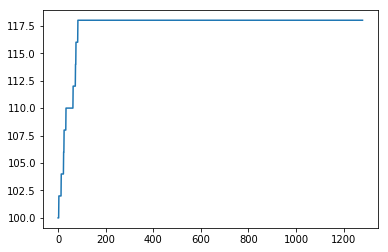

In [77]:
plt.figure()
for i in range(5):
    plt.plot(ws[i][0][0].data)

In [53]:
w0d = np.diff(np.array(ws[0][0][0].data))

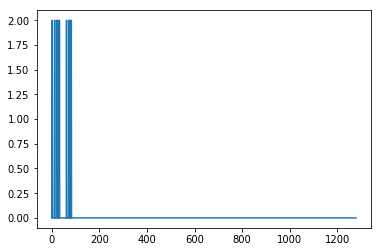

In [78]:
plt.plot(w0d)

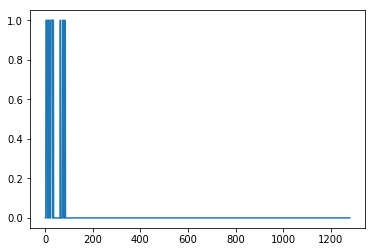

In [79]:
plt.plot(rmon[0][0].data)

In [145]:
np.sum(rmon[0].data)

192

In [75]:
net.resourceMap.reinforcementChannel(0)

[(1, 0, 0, 0)]

In [61]:
net.resourceMap.inputAxon(0)

[(1, 0, 0, 5)]

In [55]:
net.resourceMap.inputAxonMap

In [ ]:
net.resourceMap.inputAxonMap

In [27]:
np.unique(w0d)

array([-2,  0])

In [57]:
ind1 = np.where(np.array(data) == 0)

In [58]:
np.mean(np.array(rewards)[ind1])

0.9130434782608695

In [59]:
ind2 = np.where(np.array(data) != 0)

In [60]:
np.mean(np.array(rewards)[ind2])

0.14285714285714285

In [61]:
board.

(array([23., 20., 17., 24., 16.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <a list of 5 Patch objects>)

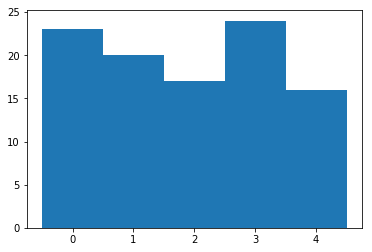

In [38]:
plt.hist(data, bins=np.arange(0,6)-0.5)

In [87]:
np.reshape(data, (epochs, 5,5))

array([[[ 0,  0,  0,  1,  0],
        [ 1,  3,  3,  0,  0],
        [ 4,  3,  2,  1,  4],
        [ 3,  6,  4,  6,  4],
        [ 7,  7,  3,  4,  6]],

       [[ 0,  2,  0,  0,  0],
        [ 3,  1,  1,  1,  1],
        [ 4,  2,  5,  4,  1],
        [ 3,  4,  6,  8,  7],
        [ 4, 10,  9,  6,  6]],

       [[ 0,  1,  0,  0,  0],
        [ 0,  1,  2,  0,  3],
        [ 2,  6,  5,  3,  4],
        [ 6,  6,  9,  4,  4],
        [11,  7, 10, 10,  8]],

       [[ 0,  0,  2,  0,  0],
        [ 1,  2,  0,  4,  4],
        [ 2,  3,  5,  2,  1],
        [ 5,  5,  1,  6,  5],
        [10, 10,  6,  8,  6]],

       [[ 0,  0,  0,  0,  0],
        [ 1,  2,  1,  3,  1],
        [ 6,  1,  2,  3,  3],
        [ 4,  3,  8,  6,  7],
        [ 5,  8,  6,  8,  9]],

       [[ 0,  0,  0,  0,  0],
        [ 1,  0,  2,  0,  1],
        [ 2,  6,  1,  2,  4],
        [ 4,  2,  3,  5,  6],
        [ 7,  6,  4,  6,  9]],

       [[ 0,  0,  0,  0,  0],
        [ 1,  2,  1,  0,  1],
        [ 8,  5,  5,  2,  2]

In [88]:
np.sum(np.reshape(data, (epochs, 5,5)), axis=2)

array([[ 1,  7, 14, 23, 27],
       [ 2,  7, 16, 28, 35],
       [ 1,  6, 20, 29, 46],
       [ 2, 11, 13, 22, 40],
       [ 0,  8, 15, 28, 36],
       [ 0,  4, 15, 20, 32],
       [ 0,  5, 22, 26, 31],
       [ 0, 10, 14, 22, 28],
       [ 1,  8, 25, 25, 34],
       [ 1, 11, 24, 20, 44]])

In [89]:
np.sum(np.reshape(data, (epochs, 5,5)), axis=(2,0))

array([  8,  77, 178, 243, 353])

In [8]:
len(counts)

250

In [9]:
rsc = np.reshape(counts, (epochs, numArms, neuronsPerArm))

In [10]:
rsc

array([[[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 7,  7,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 4, 10,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [11,  7,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [10, 10,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 5,  8,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 7,  6,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]

In [8]:
pids = np.array([[mons[j][0].probes[i].n2Probe.counterId for i in range(5)] for j in range(5)])

In [14]:
pids2 = [[mons[j][0].probes[i].n2Probe.counterId for i in range(5)] for j in range(5)]

In [17]:
pids2[-1][0]

32

In [9]:
pids

array([[36, 37, 38, 39, 40],
       [41, 42, 43, 44, 45],
       [46, 47, 48, 49, 50],
       [51, 52, 53, 54, 55],
       [32, 33, 34, 35, 56]])

In [10]:
pids[0][1]

37

In [11]:
pids_offset = pids - 32

In [12]:
pids_offset

array([[ 4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13],
       [14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23],
       [ 0,  1,  2,  3, 24]])

In [43]:
pids_offset[0,:]

array([4, 5, 6, 7, 8])

In [47]:
rsc[0,:]

array([[7, 7, 3, 4, 0],
       [0, 0, 1, 0, 1],
       [3, 3, 0, 0, 4],
       [3, 2, 1, 4, 3],
       [6, 4, 6, 4, 6]])

Get the firing counts by group and see if they make sense

In [53]:
fires = [np.array([np.ravel(rsc[i, :])[pids_offset[j,:]] for i in range(epochs)]) for j in range(numArms)]

In [54]:
len(fires)

5

In [55]:
[f.shape for f in fires]

[(10, 5), (10, 5), (10, 5), (10, 5), (10, 5)]

In [56]:
[np.sum(f) for f in fires]

[8, 77, 178, 243, 353]

In [56]:
np.sort(np.unique([[mons[j][0].probes[i].n2Probe.counterId for i in range(5)] for j in range(5)]))

array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56])

In [36]:
mons[0][0].data

array([], shape=(5, 0), dtype=int64)

In [37]:
[np.sum(mons[i][0].data,axis=1) for i in range(5)]

[array([0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0])]

In [24]:
[np.sum(mons[i][0].data,axis=1) for i in range(5)]

[array([1, 6, 4, 1, 3]),
 array([140, 139, 136, 135, 144]),
 array([136, 131, 149, 130, 144]),
 array([142, 147, 137, 150, 143]),
 array([152, 139, 144, 138, 146])]

In [23]:
[np.sum(mons[i][0].data) for i in range(5)]

[15, 694, 690, 719, 719]